# LGBM

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Import train features dataset
train_X = pd.read_csv('Data/training_set_features.csv', index_col='respondent_id')
# Import train labels dataset
train_Y = pd.read_csv('Data/training_set_labels.csv', index_col='respondent_id')
# Import test features dataset
test_X = pd.read_csv('Data/test_set_features.csv', index_col='respondent_id')

### Break up all the columns

In [3]:
# Numeric columns
num_cols = train_X.select_dtypes('number').columns

In [4]:
# Categorical columns
cat_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']

In [5]:
# Ordinal columns
ord_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']

In [6]:
train_df = train_X.join(train_Y)
print(train_df.shape)
train_df.head()

(26707, 37)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker        

### Building some Models

In [8]:
import pandas as pd
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt

In [9]:
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold
from lightgbm import LGBMClassifier

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [11]:
# Separate features and labels
features = train_df.drop(['h1n1_vaccine', 'seasonal_vaccine'], axis=1)
labels = train_df[['h1n1_vaccine', 'seasonal_vaccine']]

# Define the column transformer for preprocessing
numeric_features = features.select_dtypes(include=['float64', 'int64']).columns
categorical_features = features.select_dtypes(include=['object']).columns

In [12]:
# Split the data into train and test sets with stratified sampling
X_train, X_eval, y_train, y_eval = train_test_split(features, labels, test_size=0.33, stratify=labels)

In [13]:
# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_encoder', OneHotEncoder(), cat_cols),
        ('ordinal_features', OrdinalEncoder(), ord_cols)
            ],
        remainder = 'passthrough',
        sparse_threshold=0)

In [14]:
def objective(trial, X, y):
    # Define the search space for hyperparameters
    param_grid = {
        'n_estimators'    : trial.suggest_int('n_estimators', 100, 500, step=25),
        "learning_rate"   : trial.suggest_float("learning_rate", 0.01, 0.15, step=0.0001),
        "max_depth"       : trial.suggest_int("max_depth", 3, 15),
        "reg_alpha"       : trial.suggest_float("reg_alpha", 0.01, 10, step=0.0001),
        "reg_lambda"      : trial.suggest_float("reg_lambda", 1, 100, step=0.0001),
        "subsample"       : trial.suggest_float("subsample", 0.05, 1, step=0.0001),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1, step=0.0001),
        "class_weight"    : trial.suggest_categorical("class_weight", [None, "balanced"]),
    }

    # Define the LGBM classifier
    model = LGBMClassifier(**param_grid, boosting_type='gbdt', metric='auc', objective='binary', n_jobs=-1)
    
    # Define the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
        ])
    
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        y_pred = pipeline.predict_proba(X_val_fold)[:, 1]
        score = roc_auc_score(y_val_fold, y_pred)
        scores.append(score)

    return np.mean(scores)

In [15]:
sampler = optuna.samplers.TPESampler(n_startup_trials=10)

In [16]:
# Perform optuna search to find the best hyperparameters for h1n1_vaccine
study_h1n1 = optuna.create_study(direction='maximize', sampler=sampler)
func = lambda trial: objective(trial, X_train, y_train['h1n1_vaccine'])
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_h1n1.optimize(func, n_trials=50, show_progress_bar=True)

[I 2023-12-30 16:16:35,853] A new study created in memory with name: no-name-3ecc5191-3fb6-4e2d-8c7a-989a24a29ea6


  0%|          | 0/50 [00:00<?, ?it/s]

In [17]:
# important features from h1n1 model
optuna.importance.get_param_importances(study_h1n1)

OrderedDict([('colsample_bytree', 0.4655351614429351),
             ('reg_lambda', 0.30797530285426783),
             ('subsample', 0.10147996039243078),
             ('learning_rate', 0.05396520792318474),
             ('reg_alpha', 0.051098364176938256),
             ('max_depth', 0.012694519409080951),
             ('n_estimators', 0.005542395356788178),
             ('class_weight', 0.0017090884443742307)])

In [18]:
import optuna.visualization as vis

In [19]:
# Plot parameter importance
vis.plot_param_importances(study_h1n1)

In [20]:
# Get the best hyperparameters for h1n1_vaccine
best_params_h1n1 = study_h1n1.best_params
print("Best Params for h1n1_vaccine:", best_params_h1n1)

Best Params for h1n1_vaccine: {'n_estimators': 475, 'learning_rate': 0.036000000000000004, 'max_depth': 9, 'reg_alpha': 7.2497, 'reg_lambda': 5.2895, 'subsample': 0.6174000000000001, 'colsample_bytree': 0.4625, 'class_weight': None}


In [21]:
model_h1n1 = LGBMClassifier(**best_params_h1n1, boosting_type='gbdt', metric='auc', objective='binary', n_jobs=-1)

In [22]:
# Train the pipeline with the best hyperparameters for h1n1_vaccine
pipeline_h1n1 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(n_estimators      = best_params_h1n1['n_estimators'],
                                  learning_rate     = round(best_params_h1n1['learning_rate'],4),
                                  max_depth         = best_params_h1n1['max_depth'],
                                  reg_alpha         = round(best_params_h1n1['reg_alpha'],4),
                                  reg_lambda        = round(best_params_h1n1['reg_lambda'],4),
                                  subsample         = round(best_params_h1n1['subsample'],4),
                                  colsample_bytree  = round(best_params_h1n1['colsample_bytree'],4),
                                  class_weight      = best_params_h1n1['class_weight'],
                                  boosting_type='gbdt', metric='auc', objective='binary', n_jobs=-1))
])
pipeline_h1n1.fit(X_train, y_train['h1n1_vaccine'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('categorical_encoder',
                                                  OneHotEncoder(),
                                                  ['race', 'sex',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation']),
                                                 ('ordinal_features',
                                                  OrdinalEncoder(),
                                                  ['age_group', 'education',
                                                   'income_poverty',
                                                   'employment_status'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.4625, learning_rate=0.036,
                                max_depth=9, metric='auc', n_estimators=475,
                                objective='binary', reg_alpha=7.2497,
                                reg_lambda=5.2895, subsample=0.6174))])

In [23]:
# Make predictions for h1n1_vaccine
h1n1_predictions = pipeline_h1n1.predict(X_eval)
h1n1_probabilities = pipeline_h1n1.predict_proba(X_eval)[:, 1]  # Probability of positive class (1)

In [24]:
# Calculate ROC curve and ROC AUC score for h1n1_vaccine
fpr, tpr, thresholds = roc_curve(y_eval['h1n1_vaccine'], h1n1_probabilities)
roc_auc_h1n1 = roc_auc_score(y_eval['h1n1_vaccine'], h1n1_probabilities)

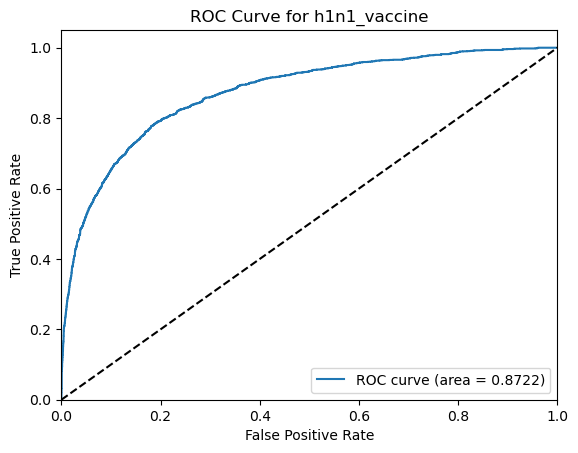

In [25]:
# Plot ROC curve for h1n1_vaccine
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc_h1n1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for h1n1_vaccine')
plt.legend(loc="lower right")
plt.show()

In [26]:
# Evaluate the model for h1n1_vaccine
print("h1n1_vaccine Classification Report:")
print(classification_report(y_eval['h1n1_vaccine'], h1n1_predictions))

h1n1_vaccine Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      6942
           1       0.74      0.52      0.61      1872

    accuracy                           0.86      8814
   macro avg       0.81      0.74      0.76      8814
weighted avg       0.85      0.86      0.85      8814



In [27]:
# Compute the confusion matrix
cm_h1n1 = confusion_matrix(y_eval['h1n1_vaccine'], h1n1_predictions)
print(cm_h1n1)

[[6593  349]
 [ 892  980]]


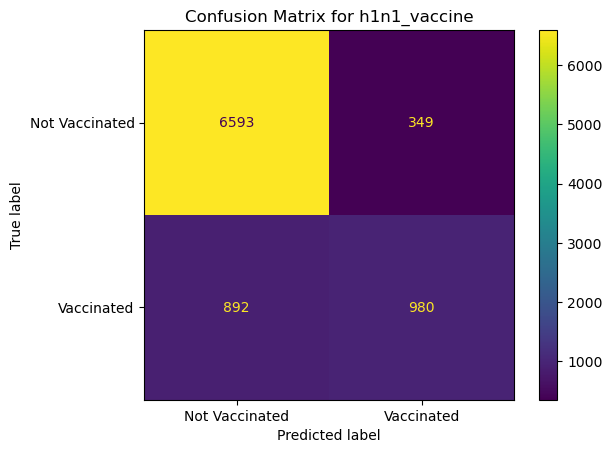

In [28]:
# Plot the confusion matrix
disp_h1n1 = ConfusionMatrixDisplay(confusion_matrix=cm_h1n1, display_labels=['Not Vaccinated', 'Vaccinated'])
disp_h1n1.plot()
plt.title('Confusion Matrix for h1n1_vaccine')
plt.show()

#### Seasonal

In [29]:
# Perform optuna search to find the best hyperparameters for seasonal_vaccine
study_seasonal = optuna.create_study(direction='maximize', sampler=sampler)
func = lambda trial: objective(trial, X_train, y_train['seasonal_vaccine'])
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_seasonal.optimize(func, n_trials=50, n_jobs=-1, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [30]:
# important features from seasonal model
optuna.importance.get_param_importances(study_seasonal)

OrderedDict([('colsample_bytree', 0.8100395503764093),
             ('learning_rate', 0.07125919997662039),
             ('max_depth', 0.05922237671618107),
             ('reg_alpha', 0.02804846230698094),
             ('class_weight', 0.017524027915216102),
             ('subsample', 0.007856200278451544),
             ('n_estimators', 0.0033048001376240563),
             ('reg_lambda', 0.002745382292516758)])

In [31]:
# Plot parameter importance
vis.plot_param_importances(study_seasonal)

In [32]:
# Get the best hyperparameters for seasonal_vaccine
best_params_seasonal = study_seasonal.best_params
print("Best Params for seasonal_vaccine:", best_params_seasonal)

Best Params for seasonal_vaccine: {'n_estimators': 450, 'learning_rate': 0.0942, 'max_depth': 10, 'reg_alpha': 4.8069, 'reg_lambda': 96.79520000000001, 'subsample': 0.25980000000000003, 'colsample_bytree': 0.3932, 'class_weight': 'balanced'}


In [33]:
model_seasonal = LGBMClassifier(**best_params_seasonal, boosting_type='gbdt', metric='auc', objective='binary', n_jobs=-1)

In [34]:
# Train the pipeline with the best hyperparameters for seasonal_vaccine
pipeline_seasonal = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(n_estimators      = best_params_seasonal['n_estimators'],
                                  learning_rate     = round(best_params_seasonal['learning_rate'],4),
                                  max_depth         = best_params_seasonal['max_depth'],
                                  reg_alpha         = round(best_params_seasonal['reg_alpha'],4),
                                  reg_lambda        = round(best_params_seasonal['reg_lambda'],4),
                                  subsample         = round(best_params_seasonal['subsample'],4),
                                  colsample_bytree  = round(best_params_seasonal['colsample_bytree'],4),
                                  class_weight      = best_params_seasonal['class_weight'],
                                  boosting_type='gbdt', metric='auc', objective='binary', n_jobs=-1))
])
pipeline_seasonal.fit(X_train, y_train['seasonal_vaccine'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('categorical_encoder',
                                                  OneHotEncoder(),
                                                  ['race', 'sex',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation']),
                                                 ('ordinal_features',
                                                  OrdinalEncoder(),
                                                  ['age_group', 'education',
                                                   'income_poverty',
                                                   'employment_status'])])),
                ('classifier',
                 LGBMClassifier(class_weight='balanced',
                                colsample_bytree=0.3932, learning_rate=0.0942,
                                max_depth=10, metric='auc', n_estimators=450,
                                objective='binary', reg_alpha=4.8069,
                                reg_lambda=96.7952, subsample=0.2598))])

In [35]:
# Make predictions for seasonal_vaccine
seasonal_predictions = pipeline_seasonal.predict(X_eval)
seasonal_probabilities = pipeline_seasonal.predict_proba(X_eval)[:, 1]  # Probability of positive class (1)

In [36]:
# Calculate ROC curve and ROC AUC score for seasonal
fpr, tpr, thresholds = roc_curve(y_eval['seasonal_vaccine'], seasonal_probabilities)
roc_auc_seasonal = roc_auc_score(y_eval['seasonal_vaccine'], seasonal_probabilities)

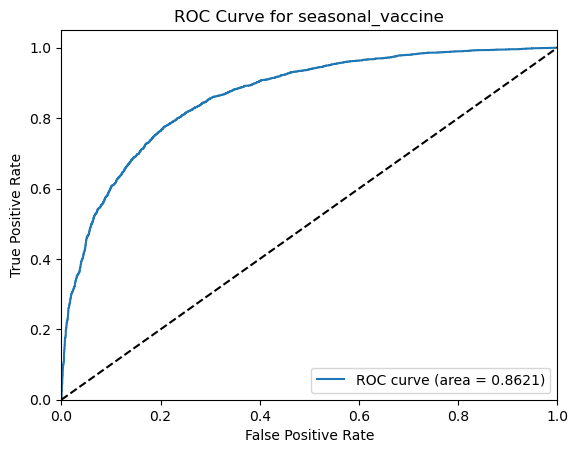

In [37]:
# Plot ROC curve for seasonal_vaccine
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc_seasonal)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for seasonal_vaccine')
plt.legend(loc="lower right")
plt.show()

In [38]:
# Evaluate the model for seasonal_vaccine
print("seasonal_vaccine Classification Report:")
print(classification_report(y_eval['seasonal_vaccine'], seasonal_predictions))

seasonal_vaccine Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      4710
           1       0.76      0.78      0.77      4104

    accuracy                           0.78      8814
   macro avg       0.78      0.78      0.78      8814
weighted avg       0.78      0.78      0.78      8814



In [39]:
# Compute the confusion matrix
cm_seasonal = confusion_matrix(y_eval['seasonal_vaccine'], seasonal_predictions)
print(cm_seasonal)

[[3706 1004]
 [ 905 3199]]


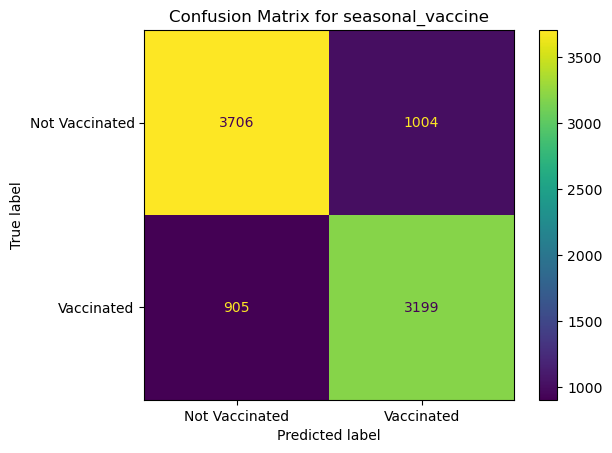

In [40]:
# Plot the confusion matrix
disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=cm_seasonal, display_labels=['Not Vaccinated', 'Vaccinated'])
disp_seasonal.plot()
plt.title('Confusion Matrix for seasonal_vaccine')
plt.show()

In [41]:
# Calculate average ROC AUC score
average_roc_auc = (roc_auc_h1n1 + roc_auc_seasonal) / 2

# Print the average ROC AUC score
print("Average ROC AUC Score:", average_roc_auc)

Average ROC AUC Score: 0.8671700691598221


---

### Retrain Model on Full Dataset

In [42]:
%%time 

# Training H1N1 pipeline on full train dataset
pipeline_h1n1.fit(train_X, train_Y['h1n1_vaccine'])

None   # So we don't print out the whole pipeline representation

CPU times: total: 13.8 s
Wall time: 1.13 s


In [43]:
# Want to see top 10 features
N = 10

In [44]:
a = train_X
b = train_Y['h1n1_vaccine']

# transform the train by using the data cleaning stuff above to fill in missing data and create dummy variables
processed_data = preprocessor.fit_transform(a, b)

categorical_feature_names = preprocessor.named_transformers_['categorical_encoder'].get_feature_names_out(cat_cols)
 
all_feature_names = list(numeric_features) + list(categorical_feature_names) + list(ord_cols)
 
# Convert the processed data array back into a DataFrame
X_h1n1_train = pd.DataFrame(processed_data, columns=all_feature_names)

In [45]:
# Get feature importances for h1n1_vaccine model
importance_h1n1 = pipeline_h1n1.named_steps['classifier'].feature_importances_

# Create a DataFrame to show feature importances
feature_importances_h1n1 = pd.DataFrame({'Feature': X_h1n1_train.columns, 'Importance': importance_h1n1})
# Sort by importance in descending order
feature_importances_h1n1 = feature_importances_h1n1.sort_values(by='Importance', ascending=False)

# Display the top N most important features for h1n1_vaccine model
print("Feature Importances for h1n1_vaccine:")
print(feature_importances_h1n1.head(N))

Feature Importances for h1n1_vaccine:
                           Feature  Importance
91  employment_occupation_xtkaffoo         782
72  employment_occupation_cmhcxjea         727
93       employment_occupation_nan         717
94                       age_group         682
90  employment_occupation_xqwwgdyp         671
71  employment_occupation_ccgxvspp         610
92  employment_occupation_xzmlyyjv         609
95                       education         529
73  employment_occupation_dcjcmpih         516
85  employment_occupation_tfqavkke         500


In [46]:
%%time 

# Training seasonal pipeline on full train dataset
pipeline_seasonal.fit(train_X, train_Y['seasonal_vaccine'])

None   # So we don't print out the whole pipeline representation

CPU times: total: 14.8 s
Wall time: 1.39 s


In [47]:
a = train_X
b = train_Y['seasonal_vaccine']

# transform the train by using the data cleaning stuff above to fill in missing data and create dummy variables
processed_data = preprocessor.fit_transform(a, b)
 

categorical_feature_names = preprocessor.named_transformers_['categorical_encoder'].get_feature_names_out(cat_cols)
 
all_feature_names = list(numeric_features) + list(categorical_feature_names) + list(ord_cols)
 
# Convert the processed data array back into a DataFrame
X_seasonal_train = pd.DataFrame(processed_data, columns=all_feature_names)

In [48]:
# Get feature importances for seasonal_vaccine model
importance_seasonal = pipeline_seasonal.named_steps['classifier'].feature_importances_

# Create a DataFrame to show feature importances
feature_importances_seasonal = pd.DataFrame({'Feature': X_seasonal_train.columns, 'Importance': importance_seasonal})
# Sort by importance in descending order
feature_importances_seasonal = feature_importances_seasonal.sort_values(by='Importance', ascending=False)

# Display the top N most important features for seasonal_vaccine model
print("Feature Importances for seasonal_vaccine:")
print(feature_importances_seasonal.head(N))

Feature Importances for seasonal_vaccine:
                           Feature  Importance
95                       education         639
93       employment_occupation_nan         635
94                       age_group         598
91  employment_occupation_xtkaffoo         581
72  employment_occupation_cmhcxjea         577
92  employment_occupation_xzmlyyjv         499
90  employment_occupation_xqwwgdyp         499
71  employment_occupation_ccgxvspp         472
74  employment_occupation_dlvbwzss         466
96                  income_poverty         453


### Generating the Predictions for Test Set

In [49]:
test_probas_h1n1 = pipeline_h1n1.predict_proba(test_X)
test_probas_h1n1

array([[0.87094119, 0.12905881],
       [0.96129283, 0.03870717],
       [0.79558132, 0.20441868],
       ...,
       [0.83977926, 0.16022074],
       [0.97613849, 0.02386151],
       [0.46025844, 0.53974156]])

In [50]:
test_probas_seasonal = pipeline_seasonal.predict_proba(test_X)
test_probas_seasonal

array([[0.76281915, 0.23718085],
       [0.96341873, 0.03658127],
       [0.20679772, 0.79320228],
       ...,
       [0.80505595, 0.19494405],
       [0.65530534, 0.34469466],
       [0.3739509 , 0.6260491 ]])

In [51]:
submission_df = pd.read_csv("Submission_Files/submission_format.csv", index_col="respondent_id")

In [52]:
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7


In [53]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_X.index.values, submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = test_probas_h1n1[:, 1]
submission_df["seasonal_vaccine"] = test_probas_seasonal[:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.129059,0.237181
26708,0.038707,0.036581
26709,0.204419,0.793202
26710,0.695834,0.891951
26711,0.265284,0.560246


In [54]:
submission_df.to_csv('Submission_Files/submission_lgbm+optuna_50trials.csv', index=True)